In [3]:
!nvidia-smi || true

import tensorflow as tf, keras, sys, platform
print("TF:", tf.__version__, "| Keras:", keras.__version__)
print(platform.platform())

Wed Oct 29 00:00:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              8W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"swaapnikacherukuru","key":"806523de18fc8bc1a1c2593fef34ed4b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content
!unzip -q /content/chest-xray-pneumonia.zip -d /content
!find /content/chest_xray -maxdepth 2 -type d -print

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:37<00:00, 124MB/s] 
100% 2.29G/2.29G [00:37<00:00, 65.6MB/s]
/content/chest_xray
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/test
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray


In [6]:
import os, shutil, glob

# remove macOS artifact if present
shutil.rmtree("/content/chest_xray/__MACOSX", ignore_errors=True)

# if there are nested <split>/<split>/ folders, move class folders up and delete the extra level
for split in ["train", "val", "test"]:
    nested = f"/content/chest_xray/{split}/{split}"
    if os.path.isdir(nested):
        # move any subfolders/files up one level
        for item in os.listdir(nested):
            src = os.path.join(nested, item)
            dst = os.path.join(f"/content/chest_xray/{split}", item)
            # if destination already exists, skip; else move
            if not os.path.exists(dst):
                shutil.move(src, dst)
        # remove now-empty nested dir
        shutil.rmtree(nested, ignore_errors=True)

# final sanity: remove any empty directories left behind
for root, dirs, files in os.walk("/content/chest_xray", topdown=False):
    if not dirs and not files:
        try: os.rmdir(root)
        except: pass

# show final structure
!find /content/chest_xray -maxdepth 2 -type d -print

/content/chest_xray
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/test


In [7]:
import os, glob, collections

base = "/content/chest_xray"
counts = collections.OrderedDict()
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        n = len(glob.glob(os.path.join(base, split, cls, "*.jp*g")))
        counts[f"{split}/{cls}"] = n
counts

OrderedDict([('train/NORMAL', 1341),
             ('train/PNEUMONIA', 3875),
             ('val/NORMAL', 8),
             ('val/PNEUMONIA', 8),
             ('test/NORMAL', 234),
             ('test/PNEUMONIA', 390)])

In [8]:
import os, random, numpy as np, tensorflow as tf
from pathlib import Path
from collections import defaultdict

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ROOT = Path("/content/chest_xray")

def parse_patient_id(p: Path):
    # filenames like: person123_bacteria_456.jpeg
    s = p.stem.lower()
    for tok in s.split('_'):
        if tok.startswith('person'):
            return tok
    return s

# gather all image paths with labels
all_imgs = []
for split in ["train", "val", "test"]:
    for cls in ["NORMAL","PNEUMONIA"]:
        for p in (ROOT/split/cls).glob("*.jp*g"):
            all_imgs.append((str(p), 1 if cls=="PNEUMONIA" else 0, parse_patient_id(p)))

# group by patient id
by_patient = defaultdict(list)
for path, label, pid in all_imgs:
    by_patient[pid].append((path, label))

patients = list(by_patient.keys())
random.shuffle(patients)

# 70/15/15 split
n = len(patients)
n_train = int(0.7*n)
n_val   = int(0.15*n)

train_pat = set(patients[:n_train])
val_pat   = set(patients[n_train:n_train+n_val])
test_pat  = set(patients[n_train+n_val:])

def materialize(pat_set):
    files, labels = [], []
    for pid in pat_set:
        for path, lab in by_patient[pid]:
            files.append(path); labels.append(lab)
    return files, labels

train_files, train_labels = materialize(train_pat)
val_files,   val_labels   = materialize(val_pat)
test_files,  test_labels  = materialize(test_pat)

print(len(train_files), len(val_files), len(test_files))

4142 881 833


In [9]:
# Rebuild the patient sets from the file lists:
def patients_from_files(files):
    from pathlib import Path
    def parse_patient_id(p: Path):
        s = p.stem.lower()
        for tok in s.split('_'):
            if tok.startswith('person'):
                return tok
        return s
    return { parse_patient_id(Path(f)) for f in files }

train_p = patients_from_files(train_files)
val_p   = patients_from_files(val_files)
test_p  = patients_from_files(test_files)

print("overlap train∩val:", len(train_p & val_p))
print("overlap train∩test:", len(train_p & test_p))
print("overlap val∩test:", len(val_p & test_p))

overlap train∩val: 0
overlap train∩test: 0
overlap val∩test: 0


In [10]:
import numpy as np, collections

def count_labels(labels):
    c = collections.Counter(labels)
    return {"NORMAL(0)": int(c[0]), "PNEUMONIA(1)": int(c[1]), "total": int(len(labels))}

print("Train:", count_labels(train_labels))
print("Val  :", count_labels(val_labels))
print("Test :", count_labels(test_labels))

Train: {'NORMAL(0)': 1091, 'PNEUMONIA(1)': 3051, 'total': 4142}
Val  : {'NORMAL(0)': 239, 'PNEUMONIA(1)': 642, 'total': 881}
Test : {'NORMAL(0)': 253, 'PNEUMONIA(1)': 580, 'total': 833}


In [11]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 224
BATCH    = 32
SEED     = 42

In [12]:
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return img, tf.cast(label, tf.float32)

@tf.function
def augment(img, label):
    # random left-right flip
    img = tf.image.random_flip_left_right(img, seed=SEED)

    # slight brightness / contrast jitter
    img = tf.image.random_brightness(img, max_delta=0.08)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # mild zoom-in: central crop 90–100%, then resize back
    crop_frac = tf.random.uniform([], 0.90, 1.00, seed=SEED)
    new_h = tf.cast(crop_frac * IMG_SIZE, tf.int32)
    new_w = tf.cast(crop_frac * IMG_SIZE, tf.int32)
    img = tf.image.resize_with_crop_or_pad(img, new_h, new_w)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    return img, label

def make_ds(files, labels, training=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    if training:
        if shuffle:
            ds = ds.shuffle(buffer_size=2048, seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

In [13]:
train_ds = make_ds(train_files, train_labels, training=True)
val_ds   = make_ds(val_files,   val_labels,   training=False)
test_ds  = make_ds(test_files,  test_labels,  training=False)

train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

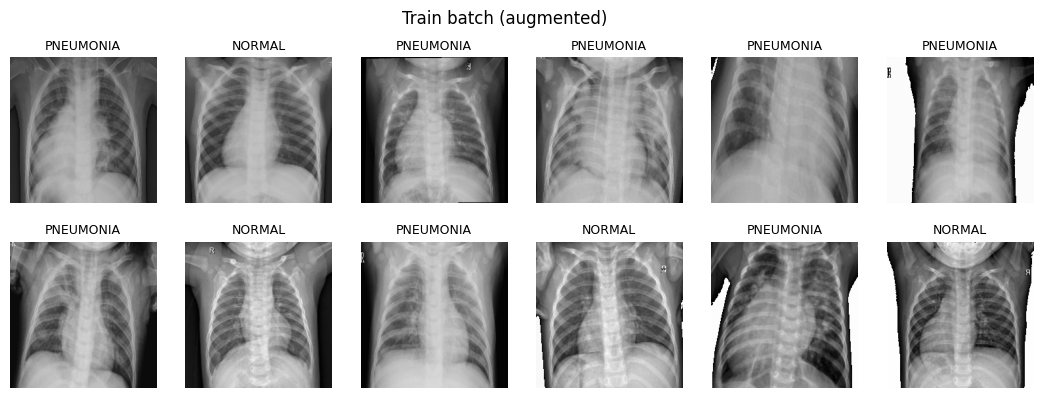

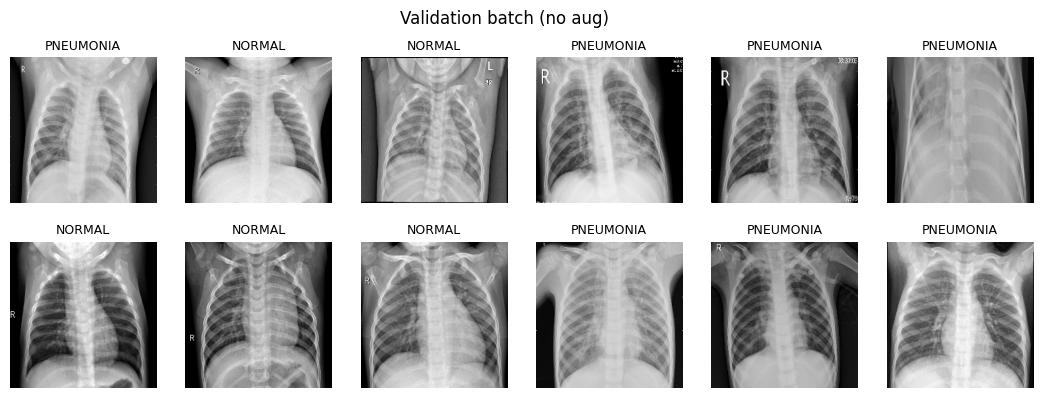

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(ds, title):
    batch = next(iter(ds))  # (images, labels)
    imgs, labs = batch
    imgs = imgs.numpy().astype("uint8")
    labs = labs.numpy().astype(int)

    n = min(12, imgs.shape[0])
    cols = 6
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.title("PNEUMONIA" if labs[i]==1 else "NORMAL", fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Train batch (augmented)")
show_batch(val_ds,   "Validation batch (no aug)")

In [15]:
from tensorflow.keras import layers as L, models, applications, callbacks

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Backbone
base = applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SHAPE
)

# Warmup
base.trainable = False

# Head
inp = L.Input(IMG_SHAPE)
x = applications.resnet.preprocess_input(inp)
x = base(x, training=False)
x = L.GlobalAveragePooling2D()(x)
x = L.Dropout(0.30)(x)
x = L.Dense(256, activation="relu")(x)
out = L.Dense(1, activation="sigmoid")(x)

model = models.Model(inp, out)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        257 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(curve="PR", name="auprc"),
    ],
)

cb_warmup = [
    callbacks.ModelCheckpoint("mvp_warmup.keras",
                              monitor="val_auprc", mode="max",
                              save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_auprc", mode="max",
                            patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_auprc", mode="max",
                                patience=2, factor=0.3, verbose=1),
]

from collections import Counter
train_counts = Counter(train_labels)
total = len(train_labels)
class_weight = {0: total/(2.0*train_counts[0]), 1: total/(2.0*train_counts[1])}
class_weight

{0: 1.8982584784601284, 1: 0.6787938380858735}

In [17]:
hist_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=cb_warmup,
    class_weight=class_weight,
)

Epoch 1/6
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - auc: 0.9294 - auprc: 0.9693 - loss: 0.3558 - precision: 0.9416 - recall: 0.8542
Epoch 1: val_auprc improved from -inf to 0.99465, saving model to mvp_warmup.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 79s 389ms/step - auc: 0.9297 - auprc: 0.9695 - loss: 0.3549 - precision: 0.9418 - recall: 0.8545 - val_auc: 0.9853 - val_auprc: 0.9946 - val_loss: 0.1346 - val_precision: 0.9642 - val_recall: 0.9657 - learning_rate: 0.0010
Epoch 2/6
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - auc: 0.9824 - auprc: 0.9923 - loss: 0.1670 - precision: 0.9780 - recall: 0.9362
Epoch 2: val_auprc improved from 0.99465 to 0.99485, saving model to mvp_warmup.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - auc: 0.9823 - auprc: 0.9922 - loss: 0.1672 - precision: 0.9780 - recall: 0.9361 - val_auc: 0.9859 - val_auprc: 0.9948 - val_loss: 0.1409 - val_precision: 0.9775 - val_recall: 0.9486 - learning_rate: 0.0010
Epoch 3/6
129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - au

In [18]:
from tensorflow.keras import layers as L, optimizers, callbacks
import math

unfreeze = 80
cnt = 0
for layer in model.layers[::-1]:
    if isinstance(layer, L.BatchNormalization):
        continue
    layer.trainable = True
    cnt += 1
    if cnt >= unfreeze:
        break

initial_lr = 1e-4
steps_per_epoch = math.ceil(len(train_files)/32)
epochs_ft = 12

lr_schedule = optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=steps_per_epoch*4,
    t_mul=2.0, m_mul=0.8
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(curve="PR", name="auprc"),
    ],
)

cb_ft = [
    callbacks.ModelCheckpoint("best_finetune.keras",
                              monitor="val_recall", mode="max",
                              save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_recall", mode="max",
                            patience=5, restore_best_weights=True),
]

hist_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_ft,
    callbacks=cb_ft,
    class_weight=class_weight,
)

Epoch 1/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - auc: 0.9837 - auprc: 0.9931 - loss: 0.1679 - precision: 0.9766 - recall: 0.9369
Epoch 1: val_recall improved from -inf to 1.00000, saving model to best_finetune.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 185s 881ms/step - auc: 0.9838 - auprc: 0.9931 - loss: 0.1678 - precision: 0.9766 - recall: 0.9370 - val_auc: 0.9253 - val_auprc: 0.9481 - val_loss: 0.5572 - val_precision: 0.8664 - val_recall: 1.0000
Epoch 2/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - auc: 0.9942 - auprc: 0.9975 - loss: 0.0839 - precision: 0.9910 - recall: 0.9713
Epoch 2: val_recall did not improve from 1.00000
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 321ms/step - auc: 0.9942 - auprc: 0.9975 - loss: 0.0838 - precision: 0.9911 - recall: 0.9713 - val_auc: 0.9646 - val_auprc: 0.9755 - val_loss: 0.3871 - val_precision: 0.8767 - val_recall: 0.9969
Epoch 3/12
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - auc: 0.9987 - auprc: 0.9995 - loss: 0.0442 - precision: 0.9940 - recall: 0.9854

<Figure size 640x480 with 0 Axes>

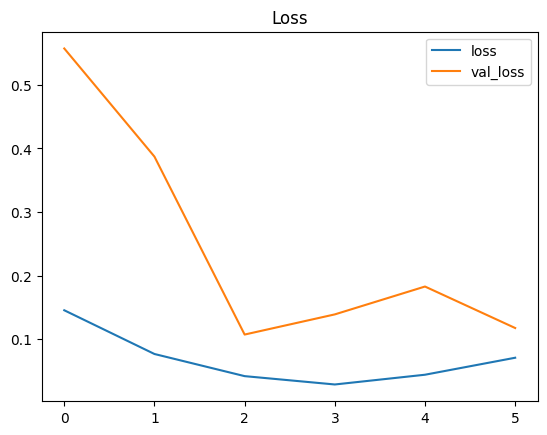

<Figure size 640x480 with 0 Axes>

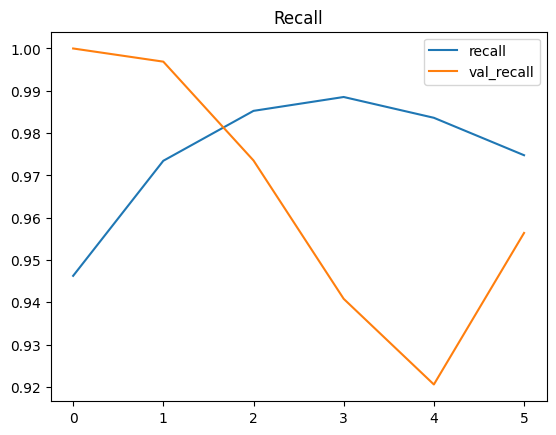

<Figure size 640x480 with 0 Axes>

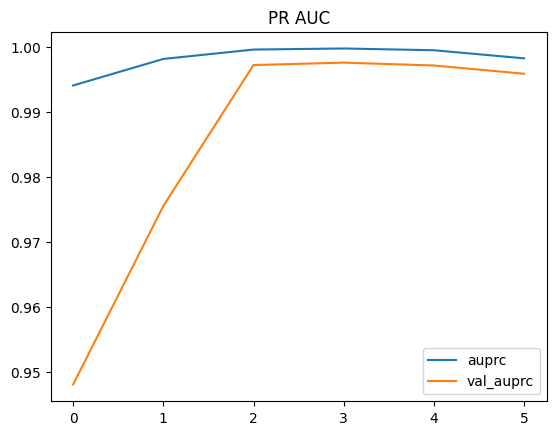

In [19]:
import pandas as pd, matplotlib.pyplot as plt
h = pd.DataFrame(hist_ft.history)
plt.figure(); h[['loss','val_loss']].plot(); plt.title("Loss"); plt.show()
plt.figure(); h[['recall','val_recall']].plot(); plt.title("Recall"); plt.show()
plt.figure(); h[['auprc','val_auprc']].plot(); plt.title("PR AUC"); plt.show()

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

val_probs = model.predict(val_ds, verbose=0).ravel()
val_y = np.array(val_labels)

ths = np.linspace(0.05, 0.95, 181)
best = None  # (thr, recall, f1, precision)

for t in ths:
    pred = (val_probs >= t).astype(int)
    tp = ((pred==1)&(val_y==1)).sum()
    fn = ((pred==0)&(val_y==1)).sum()
    fp = ((pred==1)&(val_y==0)).sum()
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    f1   = 2*prec*rec/(prec+rec+1e-9)
    if rec >= 0.90 and (best is None or f1 > best[2]):
        best = (t, rec, f1, prec)

if best is None:  # fallback: choose max recall, then best F1
    cand=[]
    for t in ths:
        pred = (val_probs >= t).astype(int)
        tp = ((pred==1)&(val_y==1)).sum()
        fn = ((pred==0)&(val_y==1)).sum()
        fp = ((pred==1)&(val_y==0)).sum()
        prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
        f1   = 2*prec*rec/(prec+rec+1e-9)
        cand.append((t, rec, f1, prec))
    best = sorted(cand, key=lambda x: (x[1], x[2]), reverse=True)[0]

best_threshold = float(best[0])
print(f"VAL threshold = {best_threshold:.3f} | Recall={best[1]:.3f} | F1={best[2]:.3f} | Precision={best[3]:.3f}")

# quick VAL sanity check
val_pred = (val_probs >= best_threshold).astype(int)
print(confusion_matrix(val_y, val_pred))
print(classification_report(val_y, val_pred, target_names=["NORMAL","PNEUMONIA"]))

VAL threshold = 0.935 | Recall=0.994 | F1=0.951 | Precision=0.911
[[177  62]
 [  4 638]]
              precision    recall  f1-score   support

      NORMAL       0.98      0.74      0.84       239
   PNEUMONIA       0.91      0.99      0.95       642

    accuracy                           0.93       881
   macro avg       0.94      0.87      0.90       881
weighted avg       0.93      0.93      0.92       881



In [21]:
import tensorflow as tf
import numpy as np

# Build logits model: log(p/(1-p))
logits_model = tf.keras.Model(
    model.input,
    tf.keras.layers.Lambda(lambda z: tf.math.log(tf.clip_by_value(z, 1e-6, 1-1e-6) / (1 - tf.clip_by_value(z, 1e-6, 1-1e-6))))(model.output)
)

val_logits = logits_model.predict(val_ds, verbose=0).ravel()
val_y_f = np.array(val_labels, dtype=np.float32)

val_logits = np.clip(val_logits, -20, 20)

T = tf.Variable(1.0, dtype=tf.float32)

def nll_temp():
    z = val_logits / (T + 1e-8)

    z = tf.clip_by_value(z, -20.0, 20.0)
    p = tf.math.sigmoid(z)
    eps = 1e-7
    return -tf.reduce_mean(val_y_f * tf.math.log(p + eps) + (1 - val_y_f) * tf.math.log(1 - p + eps))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
for _ in range(500):
    with tf.GradientTape() as tape:
        loss = nll_temp()
    grads = tape.gradient(loss, [T])
    opt.apply_gradients(zip(grads, [T]))
    T.assign(tf.clip_by_value(T, 0.1, 10.0))

T_val = float(T.numpy())
print(f"Stable Calibrated Temperature: {T_val:.4f}")

def calibrated_probs(files):
    pr = []
    for images, _ in make_ds(files, [0]*len(files), training=False):
        lg = logits_model.predict(images, verbose=0).ravel()
        lg = np.clip(lg, -20, 20)
        p_cal = 1.0 / (1.0 + np.exp(-(lg / (T_val + 1e-8))))
        pr.append(p_cal)
    return np.concatenate(pr)

Stable Calibrated Temperature: 3.0720


Confusion matrix (TEST):
 [[226  27]
 [ 26 554]]
              precision    recall  f1-score   support

      NORMAL       0.90      0.89      0.90       253
   PNEUMONIA       0.95      0.96      0.95       580

    accuracy                           0.94       833
   macro avg       0.93      0.92      0.92       833
weighted avg       0.94      0.94      0.94       833

ROC AUC (TEST): 0.978158647948753
PR  AUC (TEST): 0.9864532281768323


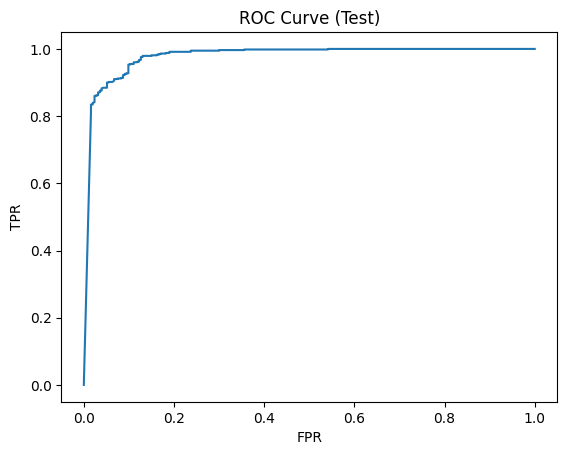

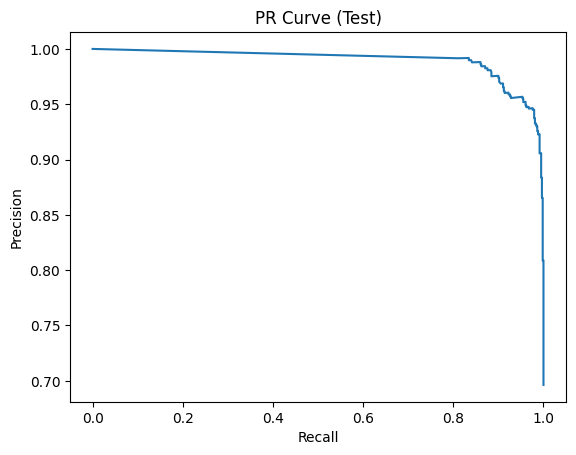

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

test_probs = calibrated_probs(test_files)
test_y     = np.array(test_labels, dtype=int)
test_pred  = (test_probs >= best_threshold).astype(int)

print("Confusion matrix (TEST):\n", confusion_matrix(test_y, test_pred))
print(classification_report(test_y, test_pred, target_names=["NORMAL", "PNEUMONIA"]))

print("ROC AUC (TEST):", roc_auc_score(test_y, test_probs))
print("PR  AUC (TEST):",  average_precision_score(test_y, test_probs))

# Curves
fpr, tpr, _        = roc_curve(test_y, test_probs)
prec, rec, _       = precision_recall_curve(test_y, test_probs)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve (Test)"); plt.show()
plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (Test)"); plt.show()

In [23]:
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path

CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

logits_model = tf.keras.Model(
    model.input,
    tf.keras.layers.Lambda(
        lambda z: tf.math.log(tf.clip_by_value(z, 1e-6, 1-1e-6) / (1.0 - tf.clip_by_value(z, 1e-6, 1-1e-6)))
    )(model.output)
)

def calibrated_probs(files):
    """Return calibrated probabilities (p*) for a list of file paths."""
    pr = []
    for images, _ in make_ds(files, [0]*len(files), training=False):
        lg = logits_model.predict(images, verbose=0).ravel()
        lg = np.clip(lg, -20, 20)
        p_cal = 1.0 / (1.0 + np.exp(-(lg / (T_val + 1e-8))))
        pr.append(p_cal)
    return np.concatenate(pr)

def predict_xray(img_or_path):
    """
    In: PIL.Image, np.ndarray, or filepath
    Out: (prob_pneumonia, label_int, diagnosis_str)
    Uses calibrated probability + tuned threshold.
    """
    if isinstance(img_or_path, (str, Path)):
        img = Image.open(img_or_path).convert("RGB")
    elif isinstance(img_or_path, Image.Image):
        img = img_or_path.convert("RGB")
    else:  # numpy array
        img = Image.fromarray(img_or_path).convert("RGB")

    img = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img, dtype=np.float32)
    x = np.expand_dims(x, 0)

    lg = logits_model.predict(x, verbose=0).ravel()[0]
    lg = float(np.clip(lg, -20, 20))
    p_cal = 1.0 / (1.0 + np.exp(-(lg / (T_val + 1e-8))))
    label = int(p_cal >= best_threshold)
    dx = f"{CLASS_NAMES[label]} | p(pneumonia)={p_cal:.3f} (thr={best_threshold:.3f})"
    return p_cal, label, dx

In [24]:
import json

model.save("/content/deeppneumo_resnet50.keras")

bundle = {
    "class_names": CLASS_NAMES,
    "IMG_SIZE": int(IMG_SIZE),
    "temperature": float(T_val),
    "threshold": float(best_threshold)
}
with open("/content/deeppneumo_config.json", "w") as f:
    json.dump(bundle, f, indent=2)

print("Saved:")
print(" - /content/deeppneumo_resnet50.keras")
print(" - /content/deeppneumo_config.json")

Saved:
 - /content/deeppneumo_resnet50.keras
 - /content/deeppneumo_config.json


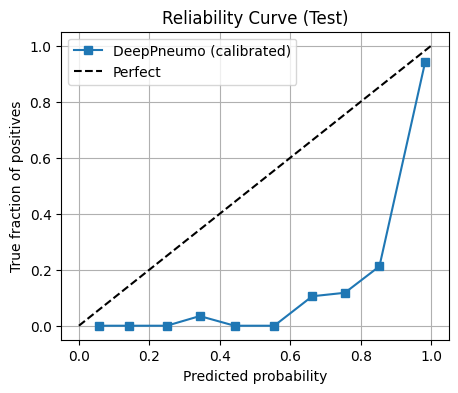

In [25]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

test_probs = calibrated_probs(test_files)
test_y     = np.array(test_labels, dtype=int)

frac_pos, mean_pred = calibration_curve(test_y, test_probs, n_bins=10, strategy="uniform")

plt.figure(figsize=(5,4))
plt.plot(mean_pred, frac_pos, "s-", label="DeepPneumo (calibrated)")
plt.plot([0,1],[0,1],"k--", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Reliability Curve (Test)")
plt.legend(); plt.grid(True); plt.show()

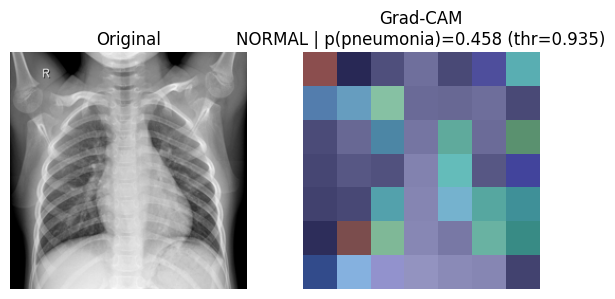

In [26]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, cv2
from PIL import Image

def _flatten_layers(layer):
    """Recursively collect all layers (handles nested Models)"""
    out = []
    stack = [layer] if hasattr(layer, "layers") else []
    while stack:
        L = stack.pop()
        out.append(L)
        if hasattr(L, "layers"):
            stack.extend(L.layers)
    return out

def _all_layers(model):
    L = []
    for l in model.layers:
        L.append(l)
        if hasattr(l, "layers"):
            L.extend(_flatten_layers(l))
    return L

def _get_feature_tensor(model):

    layers = _all_layers(model)

    # 1) Try GAP input (most stable for CAM on modern nets)
    for l in reversed(layers):
        if isinstance(l, tf.keras.layers.GlobalAveragePooling2D):
            return l.input  # 4D tensor feeding GAP

    # 2) Try last Conv2D layer
    convs = [l for l in layers if isinstance(l, tf.keras.layers.Conv2D)]
    if convs:
        return convs[-1].output

    # 3) Last fallback: any last 4D activation/tensor
    for l in reversed(layers):
        try:
            shp = l.output_shape
        except Exception:
            continue
        if isinstance(shp, tuple) and len(shp) == 4:
            return l.output

    raise RuntimeError("Could not locate a 4D feature map for Grad-CAM.")

_feature_tensor = _get_feature_tensor(model)
grad_model = tf.keras.Model(inputs=model.input, outputs=[_feature_tensor, model.output])

def gradcam_heatmap(img_array):
    """
    img_array: (1, H, W, 3) float32
    returns: 2D heatmap in [0,1]
    """
    with tf.GradientTape() as tape:
        feat, preds = grad_model(img_array, training=False)
        class_channel = preds[:, 0]

    grads = tape.gradient(class_channel, feat)                 # dY/dFeature
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)  # GAP over spatial
    cam = tf.reduce_sum(weights * feat, axis=-1)                 # weighted sum over channels
    cam = tf.maximum(cam, 0)                                     # ReLU
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam[0].numpy()

def gradcam_overlay(img_pil, heatmap, alpha=0.35):
    """
    img_pil: PIL.Image (RGB, resized to model size)
    heatmap: 2D np.array in [0,1]
    """
    img = np.array(img_pil.resize(heatmap.shape[::-1]))
    hm  = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    hm  = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)
    over = np.uint8(alpha * hm + (1 - alpha) * img)
    return Image.fromarray(over)

def visualize_gradcam(file_path):
    img = Image.open(file_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(np.array(img, dtype=np.float32), 0)
    heat = gradcam_heatmap(x)
    cam  = gradcam_overlay(img, heat)
    p, label, dx = predict_xray(img)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(cam); plt.title(f"Grad-CAM\n{dx}"); plt.axis("off")
    plt.tight_layout(); plt.show()

visualize_gradcam(test_files[0])

In [27]:
import os, csv, math, json, glob, cv2
import numpy as np
from PIL import Image
from pathlib import Path

def run_folder_inference(input_dir,
                         output_csv="/content/preds.csv",
                         save_gradcam=True,
                         cam_dir="/content/gradcam",
                         limit=None):
    os.makedirs(cam_dir, exist_ok=True)
    exts = ("*.png", "*.jpg", "*.jpeg")
    files = []
    for e in exts:
        files.extend(glob.glob(os.path.join(input_dir, e)))
    files = sorted(files)
    if limit is not None:
        files = files[:limit]
    print(f"Found {len(files)} images in {input_dir}")

    rows = [["file", "p_pneumonia", "label", "diagnosis", "threshold"]]
    for fp in files:
        # Prob + prediction
        p, label, dx = predict_xray(fp)

        # Grad-CAM (optional)
        if save_gradcam:
            img = Image.open(fp).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
            x = np.expand_dims(np.array(img, dtype=np.float32), 0)
            heat = gradcam_heatmap(x)
            cam = gradcam_overlay(img, heat, alpha=0.35)

            # Title with calibrated prob + thr
            title = f"{dx} | p(pneumonia)={p:.3f} (thr={best_threshold:.3f})"
            canvas = np.array(cam)
            cv2.putText(canvas, title, (8, 24), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)

            out_path = os.path.join(cam_dir, Path(fp).stem + "_gradcam.jpg")
            Image.fromarray(canvas).save(out_path)

        rows.append([fp, f"{p:.6f}", int(label), dx, f"{best_threshold:.6f}"])

    with open(output_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerows(rows)

    print(f"\nSaved predictions to: {output_csv}")
    if save_gradcam:
        print(f"Saved Grad-CAM overlays to: {cam_dir}")

    return rows

In [28]:
import os, glob, shutil

SRC_ROOT = "/content/chest_xray/test"
assert os.path.isdir(SRC_ROOT), f"Test set not found at {SRC_ROOT}. Re-run the Kaggle download/unzip cell."

FLAT_DIR = "/content/test_images_flat"
os.makedirs(FLAT_DIR, exist_ok=True)

exts = ("*.jpeg", "*.jpg", "*.png")
copied = 0
for sub in ("NORMAL", "PNEUMONIA"):
    subdir = os.path.join(SRC_ROOT, sub)
    assert os.path.isdir(subdir), f"Missing subdir: {subdir}"
    for e in exts:
        for fp in glob.glob(os.path.join(subdir, e)):
            shutil.copy(fp, os.path.join(FLAT_DIR, os.path.basename(fp)))
            copied += 1

print(f"Flattened {copied} files into {FLAT_DIR}")
!ls -l {FLAT_DIR} | head -n 5

Flattened 624 files into /content/test_images_flat
total 78424
-rw-r--r-- 1 root root 252680 Oct 29 00:34 IM-0001-0001.jpeg
-rw-r--r-- 1 root root 329189 Oct 29 00:34 IM-0003-0001.jpeg
-rw-r--r-- 1 root root 408620 Oct 29 00:34 IM-0005-0001.jpeg
-rw-r--r-- 1 root root 252275 Oct 29 00:34 IM-0006-0001.jpeg


In [29]:
INPUT_DIR   = FLAT_DIR
OUTPUT_CSV  = "/content/preds.csv"
GRADCAM_DIR = "/content/gradcam"

results_rows = run_folder_inference(
    input_dir=INPUT_DIR,
    output_csv=OUTPUT_CSV,
    save_gradcam=True,
    cam_dir=GRADCAM_DIR,
    limit=50
)

print(f"\n Inference complete on {len(results_rows)-1} images")
print(f"CSV: {OUTPUT_CSV}")
print(f"Grad-CAM dir: {GRADCAM_DIR}")

Found 50 images in /content/test_images_flat

Saved predictions to: /content/preds.csv
Saved Grad-CAM overlays to: /content/gradcam

 Inference complete on 50 images
CSV: /content/preds.csv
Grad-CAM dir: /content/gradcam


In [30]:
from IPython.display import Image, display
import glob, os, pandas as pd

cams = sorted(glob.glob("/content/gradcam/*.jpg"))[:6]
print(f"🩻 Found {len(cams)} Grad-CAM images. Showing up to 6:")
for c in cams:
    if os.path.exists(c) and os.path.getsize(c) > 0:
        display(Image(filename=c, width=420))

# Preview predictions
df = pd.read_csv("/content/preds.csv")
print("\n🔎 Preview of predictions:")
df.head(10)

🩻 Found 6 Grad-CAM images. Showing up to 6:



🔎 Preview of predictions:


,file,p_pneumonia,label,diagnosis,threshold
0,/content/test_images_flat/IM-0001-0001.jpeg,0.668440,0,NORMAL | p(pneumonia)=0.668 (thr=0.935),0.935
1,/content/test_images_flat/IM-0003-0001.jpeg,0.670575,0,NORMAL | p(pneumonia)=0.671 (thr=0.935),0.935
2,/content/test_images_flat/IM-0005-0001.jpeg,0.354992,0,NORMAL | p(pneumonia)=0.355 (thr=0.935),0.935
3,/content/test_images_flat/IM-0006-0001.jpeg,0.968216,1,PNEUMONIA | p(pneumonia)=0.968 (thr=0.935),0.935
4,/content/test_images_flat/IM-0007-0001.jpeg,0.534231,0,NORMAL | p(pneumonia)=0.534 (thr=0.935),0.935
5,/content/test_images_flat/IM-0009-0001.jpeg,0.550924,0,NORMAL | p(pneumonia)=0.551 (thr=0.935),0.935
6,/content/test_images_flat/IM-0010-0001.jpeg,0.742812,0,NORMAL | p(pneumonia)=0.743 (thr=0.935),0.935
7,/content/test_images_flat/IM-0011-0001-0001.jpeg,0.913938,0,NORMAL | p(pneumonia)=0.914 (thr=0.935),0.935
8,/content/test_images_flat/IM-0011-0001-0002.jpeg,0.798762,0,NORMAL | p(pneumonia)=0.799 (thr=0.935),0.935
9,/content/test_images_flat/IM-0011-0001.jpeg,0.502638,0,NORMAL | p(pneumonia)=0.503 (thr=0.935),0.935


In [31]:
import numpy as np, pandas as pd

df = pd.read_csv("/content/preds.csv")
thr = float(df["threshold"].iloc[0]) if "threshold" in df else None

y_true = df["label"].astype(int).to_numpy()
y_prob = df["p_pneumonia"].to_numpy()
y_pred = (y_prob >= thr).astype(int) if thr is not None else (y_prob >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=["NORMAL","PNEUMONIA"]))
print("ROC AUC:", roc_auc_score(y_true, y_prob))
print("PR  AUC:", average_precision_score(y_true, y_prob))
print("Threshold used:", thr)

Confusion matrix:
 [[42  0]
 [ 0  8]]

Classification report:
               precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        42
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0
PR  AUC: 1.0
Threshold used: 0.935


Saving Screenshot 2025-10-28 at 8.40.28 PM.png to Screenshot 2025-10-28 at 8.40.28 PM.png


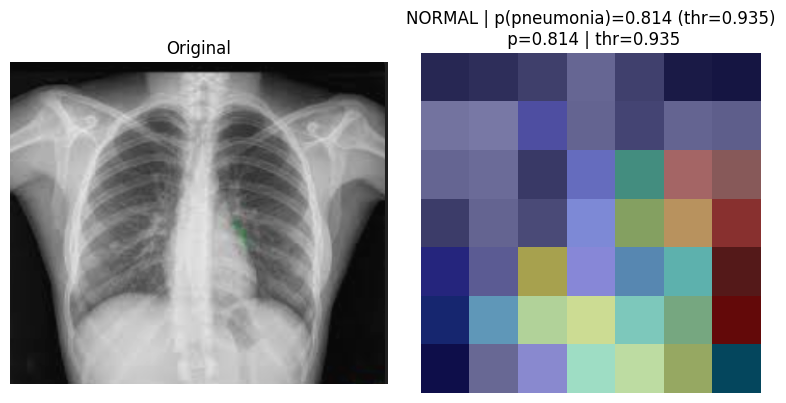

Screenshot 2025-10-28 at 8.40.28 PM.png: label=0 | NORMAL | p(pneumonia)=0.814 (thr=0.935) | p(pneumonia)=0.814 (thr=0.935)


In [36]:
from google.colab import files
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

uploaded = files.upload()

for fname, data in uploaded.items():

    img = Image.open(io.BytesIO(data)).convert("RGB")

    p, label, dx = predict_xray(img)

    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(np.array(img_resized, dtype=np.float32), 0)
    heat = gradcam_heatmap(x)
    cam  = gradcam_overlay(img_resized, heat, alpha=0.35)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(cam); plt.title(f"{dx}\n p={p:.3f} | thr={best_threshold:.3f}"); plt.axis("off")
    plt.tight_layout(); plt.show()

    print(f"{fname}: label={label} | {dx} | p(pneumonia)={p:.3f} (thr={best_threshold:.3f})")